In [ ]:
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam

# Step 1: Define Image Size and Data Directories
image_size = (224, 224)  # Adjust this according to your model's input size
train_dir = 'data/train'  # Path to training images
val_dir = 'data/val'      # Path to validation images

# Step 2: Image Preprocessing with ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize images
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',  # Binary classification (real vs forged)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',  # Binary classification
)

# Step 3: Compute Class Weights
class_labels = np.array([0, 1])  # Replace with your class labels
class_counts = np.array([sum(train_generator.classes == 0), sum(train_generator.classes == 1)])
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=class_labels, 
    y=train_generator.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class Weights: {class_weights_dict}")

# Step 4: Define the CRNN Model Architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# RNN layers (Bidirectional LSTM)
model.add(Reshape((image_size[0]//4, image_size[1]//4 * 64)))  # Reshape for RNN input
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(LSTM(64))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
epochs = 15
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    workers=1  # Disable multiprocessing for debugging
)

# Step 6: Save the Model
model.save("signature_verification_model.h5")

# Optional: Evaluate the model on test data
test_dir = 'data/test'  # Path to test data (if available)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


In [55]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Bidirectional, TimeDistributed, Dropout

def create_crnn_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = TimeDistributed(Flatten())(x)

    # RNN layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)

    # Dense output
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

# Define the model
input_shape = (128, 128, 1)  # Update this based on your preprocessed image dimensions
model = create_crnn_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 32, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 32, 256)        │     2,229,248 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,412,545 (9.20 MB)

 Trainable params: 2,412,545 (9.20 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from sklearn.model_selection import train_test_split
import cv2
def load_data(data_path):
    images, labels = [], []
    for label, folder in enumerate(['forged', 'real']):
        folder_path = os.path.join(data_path, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
            if img is not None:  # Check if image was loaded successfully
                img = cv2.resize(img, (128, 128))  # Resize to match input shape
                images.append(img)
                labels.append(label)
            else:
                print(f"Warning: Could not read image {img_path}")
    
    images = np.array(images).reshape(-1, 128, 128, 1) / 255.0  # Normalize
    labels = np.array(labels)
    return train_test_split(images, labels, test_size=0.2, random_state=42)


In [53]:
# Define the data path
data_path = r"C:\Users\DELL\My_django_projects\Sample\data"

# Load and split the data
X_train, X_test, y_train, y_test = load_data(data_path)
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (418, 128, 128, 1), Labels shape: (418,)
Testing data shape: (105, 128, 128, 1), Labels shape: (105,)


In [61]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Adjust as needed
    batch_size=32,  # Adjust based on your system memory
    verbose=1
)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - accuracy: 0.5324 - loss: 0.6892 - val_accuracy: 0.5238 - val_loss: 0.6922
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.5514 - loss: 0.6884 - val_accuracy: 0.4667 - val_loss: 0.7005
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.5404 - loss: 0.6850 - val_accuracy: 0.4857 - val_loss: 0.6940
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.5477 - loss: 0.6599 - val_accuracy: 0.4952 - val_loss: 0.7001
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.5826 - loss: 0.6565 - val_accuracy: 0.4762 - val_loss: 0.7102
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.5821 - loss: 0.6310 - val_accuracy: 0.4857 - val_loss: 0.7868
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.6196 - loss: 0.6148 - val_accuracy: 0.4952 - val_loss: 0.7869
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - accuracy: 0.6321 - loss: 0.6361 - val_accu

In [57]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 47.62%


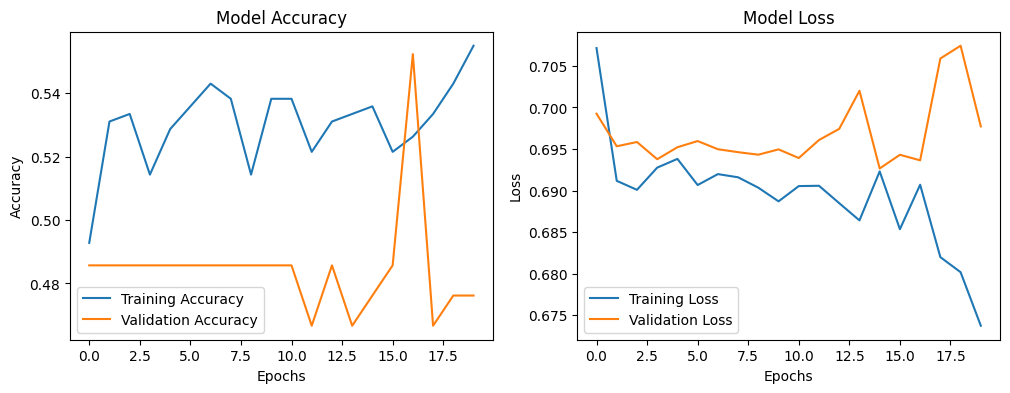

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment training data
datagen.fit(X_train)


In [11]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,  # Increase epochs if augmentation slows down convergence
    verbose=1
)


Epoch 1/30


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.5394 - loss: 0.7422 - val_accuracy: 0.4667 - val_loss: 0.7516
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.5147 - loss: 0.7261 - val_accuracy: 0.4952 - val_loss: 0.7031
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.4692 - loss: 0.7172 - val_accuracy: 0.4667 - val_loss: 0.7212
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - accuracy: 0.5240 - loss: 0.6916 - val_accuracy: 0.4762 - val_loss: 0.7205
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.5376 - loss: 0.6981 - val_accuracy: 0.4857 - val_loss: 0.7136
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.5427 - loss: 0.6896 - val_accuracy: 0.4762 - val_loss: 0.7152
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.5089 - loss: 0.6944 - val_accuracy: 0.4667 - val_loss: 0.7145
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.5087 - loss: 0.6973 - val_accuracy: 0.4762 - val_

In [12]:
def create_crnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # Enhanced CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = TimeDistributed(Flatten())(x)

    # Enhanced RNN layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)

    # Output
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

# Create and compile the model
model = create_crnn_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [17]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (418, 128, 128, 1)
X_test shape: (105, 128, 128, 1)
y_train shape: (418,)
y_test shape: (105,)


In [49]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(data_path):
    images, labels = [], []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']  # Add other extensions if needed

    # Loop over the 'forged' and 'real' folders
    for label, folder in enumerate(['forged', 'real']):
        folder_path = os.path.join(data_path, folder)
        for filename in os.listdir(folder_path):
            # Check if the file is an image
            if os.path.splitext(filename)[1].lower() in valid_extensions:  
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
                if img is not None:  # Check if image was loaded successfully
                    img = cv2.resize(img, (128, 128))  # Resize to match input shape
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Could not read image {img_path}")
            else:
                print(f"Skipping non-image file: {filename}")
    
    # Convert to numpy arrays and normalize
    images = np.array(images).reshape(-1, 128, 128, 1) / 255.0  # Normalize image pixel values
    labels = np.array(labels)  # Convert labels to numpy array

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

# Example usage
data_path = r"C:\Users\DELL\My_django_projects\Sample\data"  # Specify the path to your dataset
X_train, X_test, y_train, y_test = load_data(data_path)

# Check shapes
print(f"Training images shape: {X_train.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Skipping non-image file: 0_sign_forge_31531273_06-02-2022.csv
Skipping non-image file: 0_sign_31502418_06-02-2022.csv
Skipping non-image file: 17_sign_31502418_03-02-2022.csv
Training images shape: (418, 128, 128, 1)
Test images shape: (105, 128, 128, 1)
Training labels shape: (418,)
Test labels shape: (105,)


In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping

def create_crnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # RNN Layers (Bidirectional LSTM)
    x = Reshape((-1, 256))(x)  # Reshape for RNN input
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    # Dense Output Layer
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

# Create the model
model = create_crnn_model((128, 128, 1))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.5000 - loss: 0.6972 - val_accuracy: 0.4857 - val_loss: 0.6954
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5190 - loss: 0.6943 - val_accuracy: 0.4857 - val_loss: 0.6972
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/step - accuracy: 0.5495 - loss: 0.6913 - val_accuracy: 0.4857 - val_loss: 0.6962
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.5408 - loss: 0.6926 - val_accuracy: 0.4857 - val_loss: 0.6961
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step - accuracy: 0.4999 - loss: 0.6936 - val_accuracy: 0.4857 - val_loss: 0.6937
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.4827 - loss: 0.6938 - val_accuracy: 0.4857 - val_loss: 0.6940
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5203 - loss: 0.6923
Test Accuracy: 48.57%
